# Convex Optimization - SCIA 2018
## Report for the OCVX2 project

- We are the group composed of:
    - Alaa Bakhti
    - Hamza Senhaji Rhazi
    - Xavier Yvonne
    
- In this notebook, you will find the code used for the generation of the graphs in the report.    

In [2]:
%pylab
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.optimize import minimize, optimize, approx_fprime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import axes3d
import pickle

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# 1. Gradient Descent without Constraints
##  1.1 Gradient Descent convergence rate
- Impact of __condition number__ of __Hessian__ matrix on the convergence rate of the Gradient Descent method.

- We define the condition number of a twice differentiable function as the condition number of its Hessian matrix, namely the ratio of its largest eigenvalue (in module) over its smallest eigenvalue.

- Let $\mu \in (1;\,+\infty)$. Consider the symmetric positive definite matrix
$$A_{\mu} = \begin{pmatrix} 1 & 0 \\ 0 & \mu \end{pmatrix}.$$
- It is straightforward to see that its condition number is $\kappa(A_{\mu}) = \frac{\mu}{1} = \mu$, and its eigenvectors are $e_1 = \left(\begin{smallmatrix} 1 \\ 0 \end{smallmatrix}\right)$ and $e_2 = \left(\begin{smallmatrix} 0 \\ 1 \end{smallmatrix}\right)$. We rotate these eigenvectors with an angle $\theta = \frac{\pi}{3}$, which amounts to applying to them the rotation matrix
$$R_{\theta} = \begin{pmatrix} \cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{pmatrix}
 = \frac{1}{2} \begin{pmatrix} 1 & -\sqrt{3} \\ \sqrt{3} & 1 \end{pmatrix}$$ and to replacing
$A_{\mu}$ by $$H_{\mu} = R_{\theta}^{-1} A_{\mu} R_{\theta} = {R_{\theta}}^{T} A_{\mu} R_{\theta}.$$
- We make this rotation, because we do not want the eigenvectors be colinear to the canonical basis, otherwise the analysis of the gradient descent for the $\ell_1$-norm is more confusing.
- Now, we view $\frac{1}{2} H_{\mu}$ as a quadratic form, giving rise to the function $f_{\mu}$ defined by
\begin{equation} \tag{$*$}
f_{\mu} (W) \ = \frac{1}{2} W^T  H_{\mu} W \qquad
\big( W = \left(\begin{smallmatrix} x \\ y \end{smallmatrix}\right) \in R^2 \big).
\end{equation}

- It it easy to see (\eg, by computing the second order partial derivatives) that the Hessian matrix of $f$ at any point $W$ is actually $H_{\mu}$, so the condition number of $f$ is $\kappa(H_{\mu})$. But the matrices $H_{\mu}$ and $A_{\mu}$ are conjugate, so they share the same eigenvalues and hence the same condition number $\kappa(A_{\mu})$, which we saw is $\mu$.

- __Conclusion: for all $\mu \in (1;\,+\infty)$, the condition number of the function $f_{\mu}$ defined by $(*)$ is $\mu$.__

- Here we will start by defining some functions that will be used for exploration, and some as tools.

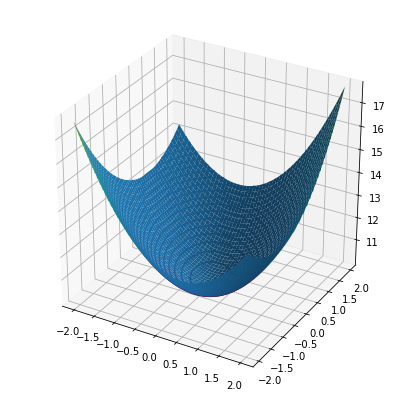

In [3]:
def f1(W, mu=2, theta=sp.pi/3, args=None):
    if args:
        if 'mu' in args:
            mu = args['mu']
        if 'theta' in args:
            theta = args['theta']
    return 1/2 * ((np.cos(theta)**2 + mu * np.sin(theta)**2) * W[0]**2 + \
          2 * (mu - 1) * np.cos(theta) * np.sin(theta) * W[0] * W[1] + \
          (mu * np.cos(theta)**2 + np.sin(theta)**2) * W[1]**2) + 10

def df1(W, mu=2, theta=sp.pi/3, args=None):
    if args:
        if 'mu' in args:
            mu = args['mu']
        if 'theta' in args:
            theta = args['theta']
    dx = (np.cos(theta)**2 + mu * np.sin(theta)**2) * W[0] + \
          (mu - 1) * np.cos(theta) * np.sin(theta) * W[1]
    dy = (mu - 1) * np.cos(theta) * np.sin(theta) * W[0] + \
          (mu * np.cos(theta)**2 + np.sin(theta)**2) * W[1]
    return np.array([dx, dy])

def f2(W, mu=2.65, args=None):
    if args and 'mu' in args:
        alpha = args['mu']
    alpha = 0.5 * np.sqrt((1 + mu**2 + 1 - 4 * mu**2 + mu**4 - mu - mu**3)) / mu
    return alpha * W[0]**2 + W[1]**2 + W[0] * W[1]

def df2(W, mu=2.65, args=None):
    if args and 'mu' in args:
        mu = args['mu']
    alpha = 0.5 * np.sqrt((1 + mu**2 + 1 - 4 * mu**2 + mu**4 - mu - mu**3)) / mu
    dx = 2 * alpha * W[0] + W[1]
    dy = 2 * W[1] + W[0]
    return np.array([dx, dy])

def get_norm1(objective_derivate, W, args):
    dw = objective_derivate(W, args=args)
    idx_max = np.argmax(dw)
    one_hot = np.zeros(dw.shape)
    one_hot[idx_max] = 1
    return dw * one_hot

def plot_2d(objective_function, args=None, val_array=None, nb_pts=50, three_dim=False, fig_size=7):
    """ val_array = the GD guesses """
    xmesh, ymesh = np.mgrid[-2:2:50j,-2:2:50j]
    fmesh = objective_function(np.array([xmesh, ymesh]), args=args)
    fig = plt.figure(figsize=(fig_size, fig_size))
    if three_dim:
        ax = fig.gca(projection="3d")
        ax.plot_surface(xmesh, ymesh, fmesh)
    plt.axis("equal")
    plt.contour(xmesh, ymesh, fmesh, nb_pts)
    if val_array is not None:
        plt.plot(val_array.T[0], val_array.T[1], "x-")
    plt.show()
    
def plot_2(objective_function, path, minima, title, x_label='$x$', y_label='$y$'):
    xmin, xmax= -4.5,4.5
    xmesh, ymesh = np.mgrid[xmin:xmax:50j,xmin:xmax:50j]
    fmesh = objective_function(np.array([xmesh, ymesh]))
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.axis("equal")
    plt.contour(xmesh, ymesh, fmesh, 50)
    ax.quiver(path.T[0,:-1], path.T[1,:-1], path.T[0,1:]-path.T[0,:-1], path.T[1,1:]-path.T[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    #plt.scatter(path.T[0], path.T[1], s=10, color='k')
    ax.plot(*minima, 'r*', markersize=18)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title, y=1.08, fontweight="bold")

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((xmin, xmax))
    plt.show()    

def plot_arr(val_arr, step, x_label='condition number', y_label='nb iteration',
             title='Gradient Descent with L1 and L2 norm, step = '):
    # Plot Norm 1
    plt.plot(val_arr[0], val_arr[1], c='b', label='L1 norm')
    # Plot Norm 2
    plt.plot(val_arr[0], val_arr[2], c='r', label='L2 norm')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title + str(step), y=1.08, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def gradient_descent(objective_derivate, args=None, tolerance=1e-5, lr=0.07,
                     max_iter=1e5, norm1=False):
    iter_idx = 0 # iteration index
    w = np.array([4, -4], dtype=float64)
    decay = np.full(w.shape, tolerance + 10, dtype=float64)
    w_arr = []
    while np.linalg.norm(decay) > tolerance and iter_idx < max_iter:
        if norm1:
            decay = lr * get_norm1(objective_derivate, w, args)
        else:
            #decay = lr * approx_fprime(w, objective_function, lr)
            decay = lr * objective_derivate(w, args=args)
        w -= decay
        w_arr.append(np.array(w))
        iter_idx += 1
    return np.array(w_arr), iter_idx if np.linalg.norm(decay) <= tolerance \
                else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)    


args = {'mu' : 2, 'theta': sp.pi/3}

plot_2d(f1, args=args, three_dim=True)

### 1.1.1 Constant step
- For the impact of condition number on the rate of convergence we will be using another function, where we had some interesting graphs.
$$f_2(x, y) = a * x^2 + y^2 + x * y$$
- $f_2(x, y)$ is convex if $a > 1/4$.

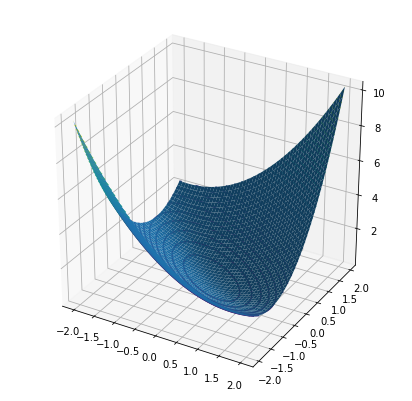

In [4]:
plot_2d(f2, args=args, three_dim=True)

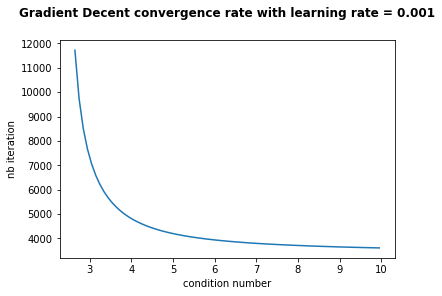

In [5]:
dim = 2
lr = 0.001
objective_function, objective_derivate = f2, df2

W0 = np.random.rand(dim)
mu_array = np.arange(2.65, 10,0.1)
arr = np.zeros((2, len(mu_array)))
for idx, mu in enumerate(mu_array):
    args = {'mu' : mu}
    W_arr, nb_iter = gradient_descent(objective_derivate, args=args, lr=lr)
    arr[:,idx] = [mu, nb_iter]

plt.plot(arr[0], arr[1])


plt.ylabel('nb iteration')
plt.xlabel('condition number')
plt.title('Gradient Decent convergence rate with learning rate = ' + str(lr),
                  y=1.08, fontweight="bold")
plt.show()

- The convergence rate of the function decreases when the condition number of the Hessian matrix increases! (Strange behavior! we expected the opposite behavior!)

### 1.1.2 Different steps:

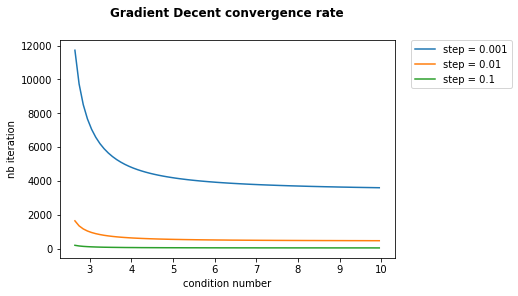

In [6]:
dim = 2
objective_function, objective_derivate = f2, df2

W0 = np.random.rand(dim)
mu_array = np.arange(2.65, 10,0.1)
for lr in [0.001, 0.01, 0.1]:
    arr = np.zeros((2, len(mu_array)))
    for idx, mu in enumerate(mu_array):
        args = {'mu' : mu}
        W_arr, nb_iter = gradient_descent(objective_derivate, args=args, lr=lr)
        arr[:,idx] = [mu, nb_iter]
    plt.plot(arr[0], arr[1], label="step = " + str(lr))


plt.ylabel('nb iteration')
plt.xlabel('condition number')
plt.title('Gradient Decent convergence rate',
                  y=1.08, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

- When the step increases, the convergence rate decreases.

## 1.2 Gradient Descent: L1 norm vs L2 norm 

- Recall that one iteration of the gradient descent, regardless of the norm, is given by

$$W' = W + \alpha \Delta W_{sd},$$

where $W$ is the old value of the current point, $W'$ is its new value, $\alpha$ is the step and 
$\Delta W_{sd}$ is the steepest direction. This $\Delta W_{sd}$ is the
only contribution that depends on the norm. We saw in class that it is given by:

$$\Delta W_{sd} = \begin{cases}
\ -\nabla f_{\mu}(W) & \mbox{for the $\ell_2$-norm } \\
\ - \big((\nabla f_{\mu}(W))^T .\, e_{i^*}\big) e_{i^*} & \mbox{for the $\ell_1$-norm, 
where $i^* = \operatorname{argmax}_i \big|(\nabla f_{\mu}(W))^T .\, e_i\big|$}
.
\end{cases}$$

- The updates of $W$ for each iteration yield a sequence $(W^{(k)})$ that we can draw in $R^3$ along with the graph of $f_{\mu}$ for a given $\alpha$ and $\mu$, and for either the $\ell_1$-norm or the $\ell_2$-norm.

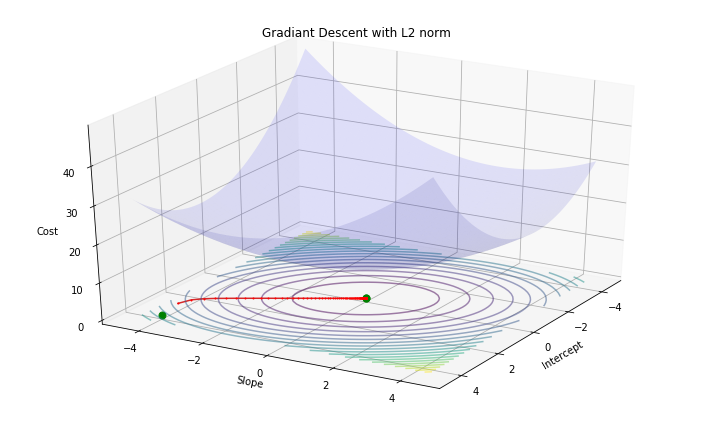

In [7]:
objective_function, objective_derivate = f1, df1

xmesh, ymesh = np.mgrid[-4.5:4.5:50j,-4.5:4.5:50j]
fmesh = objective_function(np.array([xmesh, ymesh]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xmesh, ymesh, fmesh, rstride=1, cstride=1, color='b', alpha=0.1)
ax.contour(xmesh, ymesh, fmesh, 20, color='b', alpha=0.5, offset=0, stride=30)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.set_title("Gradiant Descent with L2 norm")
ax.view_init(elev=30., azim=30)

path, nb_iter = gradient_descent(objective_derivate, args=args)

ax.plot([4], [-4], [path[-1]], '',
      markerfacecolor='g', markeredgecolor='g', marker='o', markersize=7)
ax.plot(path.T[0], path.T[1], markerfacecolor='g', markeredgecolor='r', marker='.', markersize=2);

plt.tight_layout()
plt.show()

- Observe that with the $\ell_1$-norm, the descent is always made along the coordinate axes, whereas with the $\ell_2$-norm, it tends to be along the direction of one eigenvector of the Hessian matrix computed at $W^* = \left(\begin{smallmatrix} 0 \\ 0 \end{smallmatrix}\right)$, which corresponds to a local minimum of $f_{\mu}$.  In both cases, the sequence $(W^{(k)})$ converges towards $W^*$, as expected. The convergence rate depends mainly on the norm and the condition number $\mu$. To illustrate this, we plot, for each norm, the number of iterations of the gradient descent versus the condition number $\mu$.


### 1.2.2 L2 norm 

Number of iterations = 147


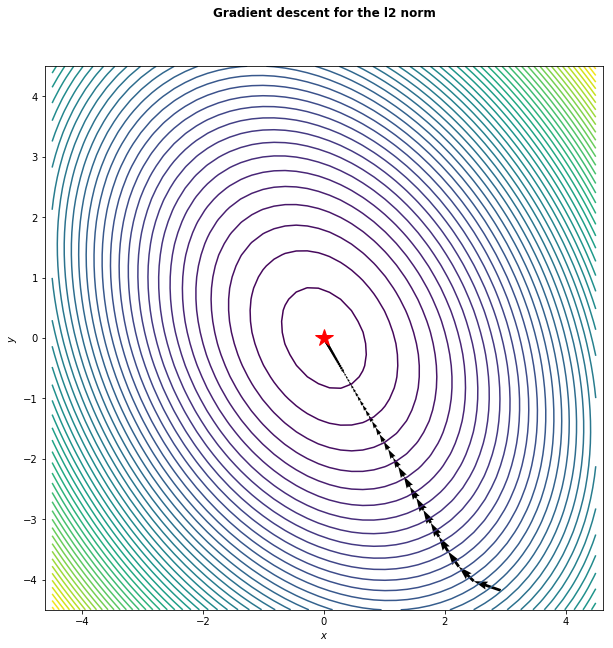

In [8]:
objective_function, objective_derivate = f1, df1
minima = np.array([0.,0.])
path, nb_iter = gradient_descent(objective_derivate, args=args, norm1=False)
print("Number of iterations = " + str(nb_iter))
plot_2(objective_function, path, minima, 'Gradient descent for the l2 norm')

### 1.2.2 L1 norm 

- Because we couldn't reproduce the graphic for the L1 norm (Implementation problem), here is a historical graphic, we produced.
![l1_norm.png](data/norm1.png)

In [9]:
def get_norm1(objective_derivate, w, args):
    dw = objective_derivate(w, args=args)
    idx_max = np.argmax(dw)
    one_hot = np.zeros(dw.shape)
    one_hot[idx_max] = 1
    return dw * one_hot

def gradient_descent(objective_derivate=df1, args=None, tolerance=1e-5, lr=0.07,
                     max_iter=1e5, norm1=False):
    iter_idx = 0 # iteration index
    w = np.array([4, -4], dtype=float64)
    decay = np.full(w.shape, tolerance + 10, dtype=float64)
    w_arr = []
    while np.linalg.norm(decay) > tolerance and iter_idx < max_iter:
        if norm1:
            decay = lr * get_norm1(objective_derivate, w, args)
        else:
            #decay = lr * approx_fprime(w, objective_function, lr)
            decay = lr * objective_derivate(w, args=args)
        w -= decay
        w_arr.append(np.array(w))
        iter_idx += 1
    return np.array(w_arr), iter_idx if np.linalg.norm(decay) <= tolerance \
                else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)   

objective_function, objective_derivate = f1, df1
minima = np.array([0.,0.])
args = {'mu' : 2, 'theta': sp.pi/3}

path, nb_iter = gradient_descent(objective_derivate, args=args, norm1=True)
print("Number of iterations = " + str(nb_iter))
#plot_2(objective_function, path, minima, 'Gradient descent for the l1 norm')

Number of iterations = 82


### L1 vs L2: Convergence rate

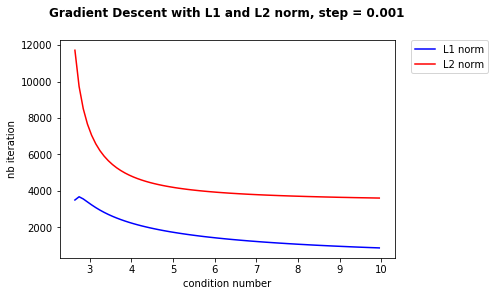

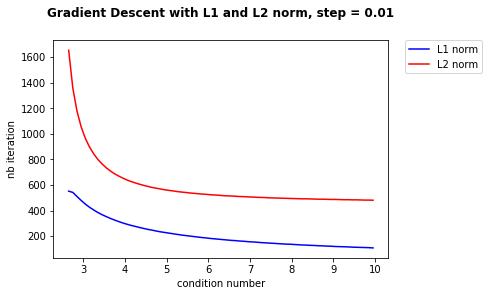

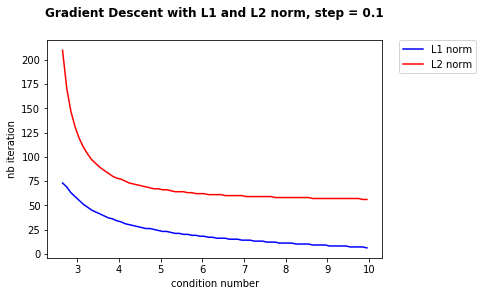

In [10]:
objective_derivate = df2

W0 = np.random.rand(2)
mu_min, mu_max, step = 2.65, 10, 0.1
mu_array = np.arange(mu_min, mu_max, step)
for step in [0.001, 0.01, 0.1]:
    arr = np.zeros((3, len(mu_array)))
    for idx, mu in enumerate(mu_array):
        args = {'mu' : mu, 'theta': sp.pi/3}
        W_arr, nb_iter_l2 = gradient_descent(objective_derivate, args=args, lr=step)
        W_arr, nb_iter_l1 = gradient_descent(objective_derivate, args=args, lr=step, norm1=True)
        arr[:,idx] = [mu, nb_iter_l1, nb_iter_l2]
    plot_arr(arr, step)

- __We note that the L1 norm always converges faster than the L2 norm. Also, the convergence rate of both norms decreases with the step (learning rate) increases.__
- L2 norm:
    - Not very robust
    - Gives a stable solution
    - Always returns one solution
- L1 norm:
    - Robust
    - Unstable solution
    - May return multiple solutions.

## 1.3 Gradient Descent VS Stochastic Gradient Descent
- In both gradient descent (GD) and stochastic gradient descent (SGD), we update a set of parameters in an iterative manner to minimize an error function.

- While in GD, we have to run through ALL the samples in our training set to do a single update for a parameter in a particular iteration, in SGD, on the other hand, we use ONLY ONE or SUBSET of training sample from our training set to do the update for a parameter in a particular iteration. If we use SUBSET, it is called Minibatch Stochastic gradient Descent.

- Thus, if the number of training samples are large, in fact very large, then using gradient descent may take too long because in every iteration when we are updating the values of the parameters, we are running through the complete training set. On the other hand, using SGD will be faster because we use only one training sample and it starts improving itself right away from the first sample.

- SGD often converges much faster compared to GD but the error function is not as well minimized as in the case of GD. Often in most cases, the close approximation that we get in SGD for the parameter values are enough because they reach the optimal values and keep oscillating there.

- If we need an example of this with a practical case, check Andrew NG's notes here where he clearly shows we the steps involved in both the cases.

Referance: https://www.quora.com/Whats-the-difference-between-gradient-descent-and-stochastic-gradient-descent

- In this part, we will be using a dataset to represent the differance between the classical Gradient Descent method and the classical Ftochastic Gradient Descent method.
- The __Height__ is the label in the dataset and the __Age__ is the data using for prediction
- Load and plot data

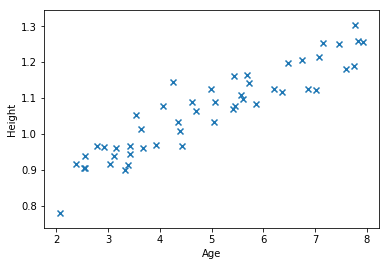

In [12]:
fin = open('data/data.pkl', 'rb')
X = np.array(pickle.load(fin))
y = np.array(pickle.load(fin))
fin.close()

plt.scatter(X, y, marker='x')
plt.xlabel('Age')
plt.ylabel('Height')
plt.show()

- Compute the correct coordinates of the line: a * x + b.
- W = (a , b)
$$W = pinv(X) Y^T$$

W =  [ 0.75016254  0.06388117]


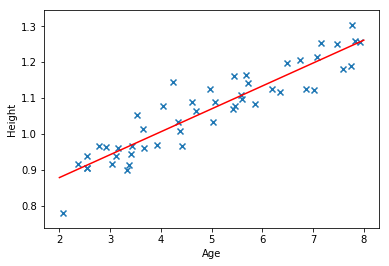

In [13]:
X_one = np.insert(X.reshape((1,50)), 0, np.ones(50)).reshape((2,50))
W = np.dot(np.linalg.pinv(X_one).T, y.T)
print("W = ", W)

plt.scatter(X, y, marker='x')
# Generate 100 points between 2 and 8
Y = np.linspace(2, 8, 100)
plt.plot(Y, Y * W[1] + W[0], color='r')
plt.xlabel('Age')
plt.ylabel('Height')
plt.show()

## 3.1 Gradient Descent
- Compute the W vector with the gradient descent method

Correct W =  [ 0.75016254  0.06388117] , Predicted W =  [ 0.74882966  0.06412367] , Nbr iteration =  659


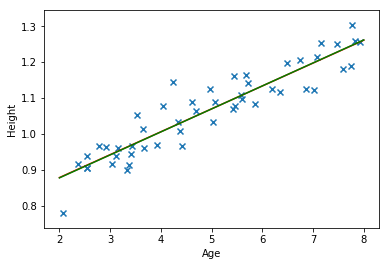

In [14]:
def gradient_descent(X, y, tolerance=1e-5, lr=0.07, max_iter=1e5):
    """
        Performs the classical gradient descent method.
         -> Performs a single update on the weight vector after iterating over all the samples.
        
        d = dimension of data
        N = nbr samples
        @param X: The data without labels. shape = (d, N)
        @param y: The data labels. shape = (N,)
        @param tolerance: The convergence threshold
        @param lr: learning rate, the step to take at each update of the weights
        @param max_iter: The maximum number of itration in case of non convergence
    """
    iter_idx = 0 # iteration index
    nb_samples = X.shape[0]
    dim = 1 #TODO: manage the case where dim > 1
    X_one = np.insert(X, 0, np.ones(nb_samples), axis=0).reshape((dim + 1, nb_samples))
    W = np.random.rand(dim + 1) # + 1 for the bias (The bias is included in W)
    delta_W = np.full(W.shape, tolerance + 10)
    W_array = [W]
    while np.linalg.norm(delta_W) > tolerance and iter_idx < max_iter:
        #dE = 2 * (W @ X_one - y) @ X
        dE = 1 / nb_samples * (X_one @ X_one.T @ W - X_one @ y.T)
        delta_W = lr * dE
        W -= delta_W
        W_array.append(W)
        iter_idx += 1
    return W_array, iter_idx

w_array, nb_iter = gradient_descent(X, y)
W_pred = w_array[-1]
print("Correct W = ", W, ", Predicted W = ", W_pred, ", Nbr iteration = ", nb_iter)

# Plot the correct and predicted weights
plt.scatter(X, y, marker='x')
Y = np.linspace(2, 8, 100)
plt.plot(Y, Y * W[1] + W[0], color='r')
plt.plot(Y, Y * W_pred[1] + W_pred[0], color='g')
plt.xlabel('Age')
plt.ylabel('Height')
plt.show()

## 3.2 Stochastic Gradient Descent

Correct W =  [ 0.75016254  0.06388117] , Predicted W =  [ 0.77985027  0.37717162] , Nbr iteration =  100000


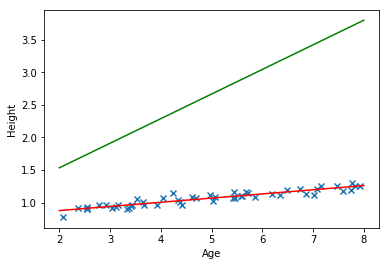

In [15]:
def stochastic_gradient_descent(X, y, nb_epochs=5, batch_size=32, tolerance=1e-5, lr=0.07, max_iter=1e3):
    """
        Performs the stochastic gradient descent method.
         -> Performs an update on the weight vector after each epoch (after visiting `batch_size` data sample).
        
        d = dimension of data
        N = nbr samples
        @param X: The data without labels. shape = (d, N)
        @param y: The data labels. shape = (N,)
        @param tolerance: The convergence threshold
        @param lr: learning rate, the step to take at each update of the weights
        @param max_iter: The maximum number of itration in case of non convergence
    """
    iter_idx = 0 # iteration index
    nb_samples = X.shape[0]
    dim = 1 #TODO: manage the case where dim > 1
    X_one = np.insert(X, 0, np.ones(nb_samples), axis=0).reshape((dim + 1, nb_samples))
    W = np.random.rand(dim + 1) # + 1 for the bias (The bias is included in W)
    delta_W = np.full(W.shape, tolerance + 10)
    W_array = [W]
    nb_batch = nb_samples // batch_size # if nb_samples % batch_size == 0 else nb_samples // batch_size + 1
    while iter_idx < max_iter:
        for batch_idx in range(0, nb_batch):
            # sample_idx_batch = [0 .. batch_size]
            dE = np.zeros(W.shape)
            for sample_idx_batch in range(0, batch_size):
                sample_idx = batch_size * batch_idx + sample_idx_batch
                dE += (X_one[:,sample_idx] * X_one[:,sample_idx].T * W - X_one[:,sample_idx] * y[sample_idx].T)
            delta_W = lr / batch_size * dE
            W -= delta_W
            W_array.append(W)
            iter_idx += 1
            if np.linalg.norm(delta_W) > tolerance:
                break
    return W_array, iter_idx

w_array, nb_iter = stochastic_gradient_descent(X, y, batch_size=1, max_iter=1e5)
W_pred = w_array[-1]
print("Correct W = ", W, ", Predicted W = ", W_pred, ", Nbr iteration = ", nb_iter)

# Plot the correct and predicted weights
plt.scatter(X, y, marker='x')
Y = np.linspace(2, 8, 100)
plt.plot(Y, Y * W[1] + W[0], color='r')
plt.plot(Y, Y * W_pred[1] + W_pred[0], color='g')
plt.xlabel('Age')
plt.ylabel('Height')
plt.show()

- Unfortunately, our stochastic gradient descent algorithm diverges, and do not find the solution.
#### Why we did not mention the stochastic gradient descent in class?
- Because we were lacking of time and moreover it was not of prime intersest for us: let us explain why. With good assumptions and parameters, both gradient descents converge toward a $W^*$ corresponding to a local minimum of the objective function $f$. For the standard gradient descent, this $W^*$ lies in the same valley as the starting point, so if $f$ has several local minima, the optimization may not be good. The SGO overcomes this problem, but is much slower and is not required in our case, where $f$ is strictly convex and hence has a unique local (and also global) minimum.

# 2. More Advanced Techniques
## 2.1 Newton method

## 2.4 - 2.5

### Intro :

We propose in this part a presentation of newton method for non linear problem solving (second order).
In the 1st part, we will study the case of problem solving without constraint and the 2nd part, we will use **2 methods** for problem solving with constraints. These methods are differents ways of looking at the same thing.

### Part 1 : Newton method (with no constraints)

In one dimensional problem, lets consider the function $f(x)$ from R$ \\ \longrightarrow $ R and $f_T(x)$ the taylor approximation in the point $x_n$ of $f(x_n)$ is : 
$f_T(x_n+\Delta x) \approx f(x_n)+f'(x_n)\Delta x+\frac 1 2 f''(x_n) \Delta x^2$

If $x_{n + 1} = x_n+\Delta x $ is a stationary point, it means that the derivative $\frac{f_T(x_n+\Delta x) - f_T(x_n)}{\Delta x} = \frac{f'(x_n)\Delta x+\frac 1 2 f''(x_n) \Delta x^2}{\Delta x} \implies f'(x_n)\Delta x+\frac 1 2 f''(x_n) \Delta x^2 = 0$
so we could find the $\Delta x$ (the step) either by solving plynomial second order or solving the derivative $f'(x_n)+f'' (x_n) \Delta x$ which give $\Delta x = - \frac{f'(x)}{f''(x)}$

#### Higher dimensions : 

In higher dimension $f'(x) = \nabla f(x)$ the gradient of $f(x)$ and $f''(x) = \mathbf{H}f(x) $ the hessian matrix of $f(x)$ so :

$$\Delta x = \mathbf{H}f(x)^{-1} . \nabla f(x)$$

#### Gradient implementation :

In [16]:
def gradient_f(x, f):
    #f the function
    assert (x.shape[0] >= x.shape[1]), "the vector should be a column vector"
    x = x.astype(np.float64)
    N = x.shape[0]
    eps = abs(np.linalg.norm(x) *  np.finfo(np.float32).eps )
    gradient = []
    f0 = f(x)
    for i in range(N):
        xx0 = 1. * x[i]
        x[i] = x[i] + eps
        f1 = f(x)
        gradient.append(np.asscalar(np.array(f1 - f0))/eps)
        x[i] = xx0
    return np.array(gradient).reshape(x.shape)

#### Test gradient :  

In [17]:
#we consider the function func defined as xT.dot(T) 
def func(x):
    return np.asscalar(x.T.dot(x))

#if x0 =(x1, x2), func(x) = x1² + x2², so grad_f(x0, func) = (2 * x1, 2 * x2)
x0 = np.array([1., 3.]).reshape(2,1)
gradient_f(x0, func)

array([[ 2.00000038],
       [ 6.00000038]])

#### Hessian implementation

In [18]:
def hessian (x, the_func):
    N = x.shape[0]
    x = x.astype(np.float64)
    hessian = np.zeros((N,N)) 
    gd_0 = gradient_f(x, the_func)
    eps = abs(np.linalg.norm(gd_0) * np.finfo(np.float32).eps )
    for i in range(N):
        xx0 = 1.*x[i]
        x[i] = xx0 + eps
        gd_1 =  gradient_f(x, the_func)
        hessian[:,i] = ((gd_1 - gd_0)/eps).reshape(x.shape[0])
        x[i] =xx0
    return hessian

#### Test Hessian :  

In [19]:
#if x0 =(x1, x2), func(x) = x1² + x2²,the hessian matrix should be 2 * I_2 where I_2 is the identity matrix 
#of dimension 2
hessian(x0, func)

array([[  1.99999958e+00,  -1.66692680e-07],
       [ -2.86263754e-07,   1.99999912e+00]])

### Newton algorithm :
Newton algorithm supposes that the sequence $x_{n+1} = x_n + \Delta x$ converges to a stationary point $x*$
so starting from a random point $x_n$, we iterate to $x_{n+1}$ until we reach $x*$

In [20]:
def Newton(func, x0):
    tol = 1e-4
    eps = abs(np.linalg.norm(x0) *  1e-7) 
    x1 = 1. + x0
    while(np.linalg.norm(x1 - x0) > tol):
        x0 = x1
        grad = gradient_f(x0, func)
        x1 = x0 - np.linalg.inv(hessian(x0, func)).dot(grad)
    return x1

#### Test Newton algorithm :

In [21]:
#if x0 =(x1, x2), func(x) = x1² + x2², the newton algorithm applied should give the solution (0, 0)
Newton(func, x0)

array([[ -3.69603615e-09],
       [ -9.02101269e-10]])

#### Comparaison with scipy
We took a scipy example : https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [22]:
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess
x1 = [1.3, 0.7, 0.8, 1.9, 1.2]
#Comparaison with scipy
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H
res = minimize(rosen, x1, method='trust-ncg',
               jac=rosen_der, hess=rosen_hess,
               options={'gtol': 1e-8, 'disp': True})
print("scipy solution is",res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 20
         Hessian evaluations: 19
scipy solution is [ 1.  1.  1.  1.  1.]


In [23]:
res = Newton(rosen, np.array(x1).reshape(5,1))
print("implemented solution is\n",res)

implemented solution is
 [[ 0.99998572]
 [ 0.99997164]
 [ 0.99994356]
 [ 0.99988733]
 [ 0.99977453]]


### Part 2 : Newton method (with constraints)

#### Method 1 :

instead of solving the 1st problem we re-write it by considering the constraints and give the lagrangien function $L(x, \lambda)$
using lagrange multipliers https://en.wikipedia.org/wiki/Lagrange_multiplier, and apply the newton method on 
the lagrangien function and from the solution $(x*, \lambda^*)$ select $x^*$

#### Method 2 : 
Using the method explained here https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture12.pdf
we solve the system 

$$
\begin{equation}
\begin{pmatrix}
   H_f(x) & J_h(x)^T \\
   J_h(x) & 0 
\end{pmatrix}
\begin{pmatrix}
   \Delta x \\
   \lambda   
\end{pmatrix}
=
\begin{pmatrix}
   -\nabla f(x)\\
    -h(x)
\end{pmatrix}
\end{equation}
$$

where $J_h(x)$ is the jacobian matrix of the constrainsts of f denoted as $h(x)$ 

https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant

so to find our solution :

$$
\begin{equation}
\begin{pmatrix}
   \Delta x \\
   \lambda   
\end{pmatrix}
=
\begin{pmatrix}
   H_f(x) & J_h(x)^T \\
   J_h(x) & 0 
\end{pmatrix}^{-1}
\begin{pmatrix}
   -\nabla f(x)\\
    -h(x)
\end{pmatrix}
\end{equation}
$$
Where $h(x) $ are the function of constraints, they are satisfied where $h(x) = 0$
if we start from a point $x_k$ that satisfy the constraint the system become 

$$
\begin{equation}
\begin{pmatrix}
   \Delta x \\
   \lambda   
\end{pmatrix}
=
\begin{pmatrix}
   H_f(x) & J_h(x)^T \\
   J_h(x) & 0 
\end{pmatrix}^{-1}
\begin{pmatrix}
   -\nabla f(x)\\
    0
\end{pmatrix}
\end{equation}
$$

### 1st Method implem :

We take the introduction example given in wikipedia https://fr.wikipedia.org/wiki/Multiplicateur_de_Lagrange where the aim is to find a portion of the geometric figure which has a volume v0 (constraint) with the minimum surface (function to minimize), our variable are (r:radius,h:height)

Function to minimize : 

$s(r,h) = 2\pi r(r+h)$

Constraint function :

$\phi(r,h) = \pi r^2h - v_0 = 0$

Lagrangien :

$L(r,h,\lambda) = s(r,h) + \lambda\phi(r,h)$


In [24]:
def surface(x):#s(r,h)
    return 2 * np.pi * x[0]* x.sum()

In [25]:
def phi_vol(x, v0 = 100):#phi(r,h)
    return np.pi * x[0]**2 * x[1] - v0

In [26]:
def lagrangien(func, N, phis = []): #L(r,h)
    return lambda x: np.asscalar(func(x[:N]) + x[N:].T.dot(np.array([phi(x[:N]) \
                                                                     for phi in phis])).reshape(len(x[N:]),1))

In [27]:
#initialize r,h,lambda
c = np.ones(3).reshape(3,1)
#Defining the lagrangien
lag = lagrangien(surface, 2, [phi_vol])

In [ ]:
#Newton resolution : 
sol = Newton(lag, c)

### Results and comments : 
- According to Wikipedia the solution should be $h = 2r$,  here we have a solution where the first component 
$r = 2.515$ and $h = 5.029$ which seems logical. Also, the evaluation of the constraint = 0 is satisfied.

- The algorithm is not too stable (diverges) when tolerance is too small (for example 1e-6).

In [ ]:
print ("2 * r = " ,2 *  sol[0])
print ("h = " , sol[1])
print("the evaluation of the contraint thath should be equal to 0", phi_vol(sol[:2]))

### 2d Method implem :

In [ ]:
#Defining Jacobian matrix
def jacobian(x, phis):
    jac = []
    for phi in phis:
        jac.append(gradient_f(x, phi).flatten())
    return np.array(jac)

In [ ]:
#Defining Matrix Stack
def stack_mat(x, func, phis):
    J = jacobian(x, phis)
    H = hessian(x, func)
    HJ = np.hstack((H,J.T))
    n = J.shape[0]
    Z = np.zeros((n,n))
    JZ = np.hstack((J,Z))
    stack_mat = np.vstack((HJ, JZ))
    return stack_mat

In [ ]:
# we consider that the point satisfy the constraints
def delta_x_lambda(x, func, phis):
    n = len(phis)
    return np.linalg.inv(stack_mat(x, func, phis)).dot(-np.vstack((gradient_f(x, func), np.zeros((n,1)))))

In [ ]:
#We use the general formula
def delta_x_lambda2(x, func, phis):
    n = len(phis)
    invH = np.linalg.inv(stack_mat(x, func, phis))
    minus_gh = np.vstack((-gradient_f(x, func), - np.array([phi(x) for phi in phis]).reshape(n,1)))
    return  invH.dot(minus_gh)

In [ ]:
def Newton2(func, x0, sat = False):
    tol = 1e-4
    n = x0.shape[0]
    x1 = 1. + x0
    while(np.linalg.norm(x1 - x0) > tol):
        x0 = x1
        grad = gradient_f(x0, func)
        #The step here is calculated diffrently
       # print("hh")
        if(sat == False):
            x1 = x0 + delta_x_lambda(x0,surface, [phi_vol])[:n]
        else:
            x1 = x0 + delta_x_lambda2(x0,surface, [phi_vol])[:n]
    return x1

In [ ]:
xl[1] = 2 * 2.51

In [ ]:
x = np.ones(2).reshape(2,1)
#x  = sol

In [ ]:
sol = Newton2(surface, x)
sol2 = Newton2(surface, x, True)

### Results and comments
Here we do not have the result $h = 2 * r$ confirmed by this second method, We d'do not know if it is due to the implementation or not. The constraint $h(x) = 0$ is verified when we use the general formula by setting the argument sat of the Newton2 function to True.

In [ ]:
print("assuming we start from a point that satisfy constraint\n")
print ("2 * r = " ,2 *  sol[0])
print ("h = " , sol[1])
print("general formula")
print ("2 * r = " ,2 *  sol2[0])
print ("h = " , sol2[1])

In [ ]:
phi_vol(sol2)

In [ ]:
phi_vol(sol)

## 2.2 SVM & SMO

- Although we did undersand the algorithm explained in class, we did not have enough time to deal with this part of the project.

## 2.3. Interior-point Method
- We had only very little time to focus ourselves on this part of the project. Here is what we could understand from it.
- We want to solve a convex optimization problem that include inequality constraints:

$$\mbox{minimize $f_0(x)$ subject to $f i (x) \leq 0$ ($1 \leq i \leq m$) and $Ax=b$,}$$

where $f_0 ... f_m$ : $R^n \rightarrow R$ are convex and twice continuously differentiable, and $A \in R^{p \times n}$ with $\operatorname{rk}{(A)}=p<n$.

- The first idea in to get rid of the inequalities by adding an infinite penalty to the objective function $f_0$ whenever at least one of the constraint is not satisfied. More formally, we put $$I_-(u) = \begin{cases}  
+\infty & \mbox{if $u \in R,\, u > 0$} \\ 
0 & \mbox{otherwise} \end{cases},$$
and rephrase the problem as
$$\mbox{minimize $f_0(x) + \sum_{i=1}^m I_-(f_i(x))$ subject to $Ax=b$.}$$
- The trouble is, the function $I_-$ is not differentiable, so we introduce a parameter $t>0$ and replace it by
$$\widehat{J}_t(u) = \frac{-1}{t} \log(-u).$$
- Doing this and multiplying the objective function by $t$ for commodity gives the following problem:

$$\mbox{minimize $tf_0(x) + \phi(x)$ subject to $Ax=b$,}$$
where
$$\phi(x) = - \sum_{i=1}^m \log(-f_i(x))$$
is called a __logarithmic barrier function__. The new objective is convex, since $-(1/t) \log(-u)$ is convex and increasing in $u$, and differentiable. Assuming an appropriate closedness condition holds, Newton's method can then be used to solve this problem.

- The primal-dual methods starts with these considerations and writing the KKT conditions for this problem. It also implies solving such a problem by Newton's method for a given $t$.  
